# Stream Ensemble Classification
---

## `NEWeather` dataset

**Description:** The National Oceanic and Atmospheric Administration (NOAA),
has compiled a database of weather measurements from over 7,000 weather
stations worldwide. Records date back to the mid-1900s. Daily measurements
include a variety of features (temperature, pressure, wind speed, etc.) as
well as a series of indicators for precipitation and other weather-related
events. The `NEweather` dataset contains data from this database, specifically
from the Offutt Air Force Base in Bellevue, Nebraska ranging for over 50 years
(1949-1999).

**Features:** 8 Daily weather measurements

|       Attribute      | Description |
|:--------------------:|:-----------------------------|
| `temp`                   | Temperature
| `dew_pnt`                | Dew Point
| `sea_lvl_press`          | Sea Level Pressure
| `visibility`             | Visibility
| `avg_wind_spd`           | Average Wind Speed
| `max_sustained_wind_spd` | Maximum Sustained Wind Speed
| `max_temp`               | Maximum Temperature
| `min_temp`               | Minimum Temperature


**Class:** `rain` | 0: no rain, 1: rain

**Samples:** 18,159


In [1]:
import pandas as pd
from river.stream import iter_pandas
from river.metrics.base import Metrics
from river.utils import Rolling
from river.metrics import Accuracy,BalancedAccuracy,CohenKappa,GeometricMean
from river.evaluate import iter_progressive_val_score
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("/content/NEweather.csv")
features = data.columns[:-1]

In [5]:
# Function to plot the results
def plot_results(steps,plot_title,rolling):
    res = []
    for step in steps:
        if rolling:
            res.append([step['Rolling'].get()[0],step['Rolling'].get()[1],step['Rolling'].get()[2],step['Rolling'].get()[3]])
        else:
            res.append([step['Accuracy'].get(),step['BalancedAccuracy'].get(),step['GeometricMean'].get(),step['CohenKappa'].get()])
    fig = plt.figure()
    plt.plot(res, label=['Accuracy','BalancedAccuracy','GeometricMean','CohenKappa'])
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('Metrics', fontsize=13)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(plot_title)
    plt.show()

## Online Bagging

---
[Online Bagging](https://riverml.xyz/0.21.2/api/ensemble/BaggingClassifier/) is an Online bootstrap aggregation for classification.

In [45]:
from river.ensemble import BaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = BaggingClassifier(model=HoeffdingTreeClassifier(),
                          n_models=10,
                          seed=42)
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

steps_OB = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)

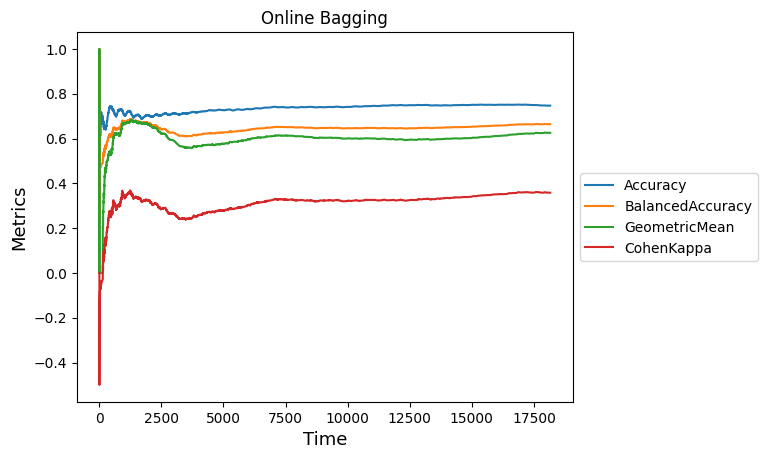

In [38]:
plot_results(steps_OB,'Online Bagging',rolling=False)

## Leveraging Bagging
---

[Leveraging Bagging](https://riverml.xyz/0.21.2/api/ensemble/LeveragingBaggingClassifier/) is an improvement over the Oza Bagging algorithm. The bagging performance is leveraged by increasing the re-sampling. It uses a poisson distribution to simulate the re-sampling process. To increase re-sampling it uses a higher w value of the Poisson distribution (agerage number of events), 6 by default, increasing the input space diversity, by attributing a different range of weights to the data samples.

To deal with concept drift, Leveraging Bagging uses the ADWIN algorithm to monitor the performance of each member of the enemble If concept drift is detected, the worst member of the ensemble (based on the error estimation by ADWIN) is replaced by a new (empty) classifier.

In [46]:
from river.ensemble import LeveragingBaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = LeveragingBaggingClassifier(model=HoeffdingTreeClassifier(),n_models=10,seed=42)
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

steps_LB = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)

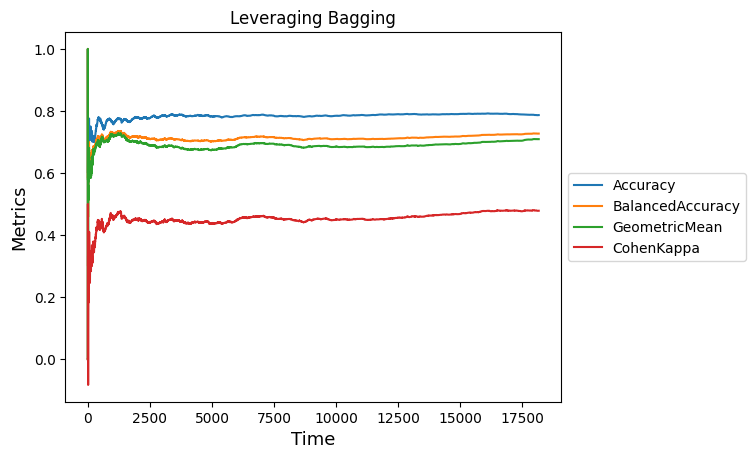

In [40]:
plot_results(steps_LB,'Leveraging Bagging',rolling=False)

## AdaptiveRandomForest
---



The 3 most important aspects of [ARF](https://riverml.xyz/0.21.2/api/forest/ARFClassifier/) are:
- inducing diversity through re-sampling
- inducing diversity through randomly selecting subsets of features for node splits
- drift detectors per base tree, which cause selective resets in response to drifts

It also allows training background trees, which start training if a warning is detected and replace the active tree if the warning escalates to a drift.

In [47]:
from river.forest import ARFClassifier

model = ARFClassifier(n_models=10)
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

steps_ARF = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)

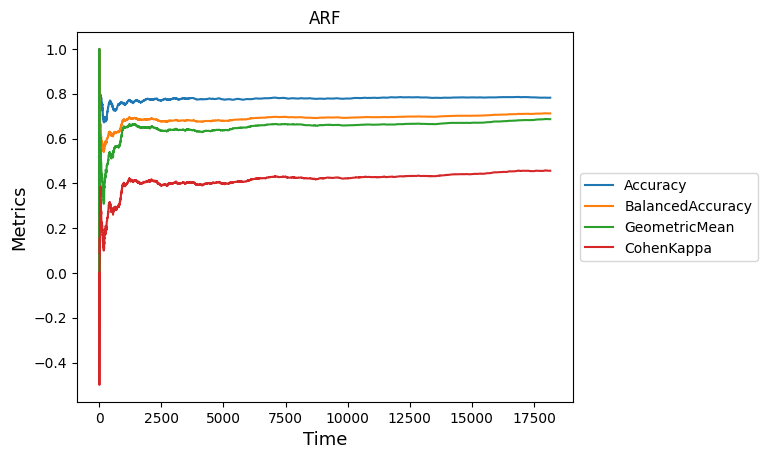

In [42]:
plot_results(steps_ARF,'ARF',rolling=False)

## StreamingRandomPatches
---
[SRP](https://riverml.xyz/0.21.2/api/ensemble/SRPClassifier/) is an ensemble method that simulates bagging or random subspaces. The default algorithm uses both bagging and random subspaces, namely Random Patches. The default base estimator is a Hoeffding Tree, but other base estimators can be used (differently from random forest variations).

In [48]:
from river.ensemble import SRPClassifier
from river.tree import HoeffdingTreeClassifier

model = SRPClassifier(model=HoeffdingTreeClassifier(),
                      n_models=10,
                      seed=42)
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

steps_SRP = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)

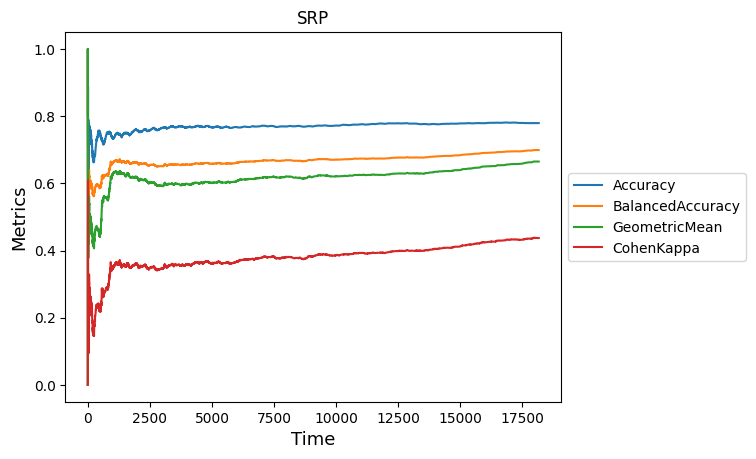

In [44]:
plot_results(steps_SRP,'SRP',rolling=False)

In [69]:
# Function to plot the comparison
def plot_comparison(steps_OB, steps_LB, steps_ARF, steps_SRP, plot_title, rolling):
    if rolling:
      res1 = [s['Rolling'].get()[3] for s in steps_OB]
      res2 = [s['Rolling'].get()[3] for s in steps_LB]
      res3 = [s['Rolling'].get()[3] for s in steps_ARF]
      res4 = [s['Rolling'].get()[3] for s in steps_SRP]
    else:
      res1 = [s['CohenKappa'].get() for s in steps_OB]
      res2 = [s['CohenKappa'].get() for s in steps_LB]
      res3 = [s['CohenKappa'].get() for s in steps_ARF]
      res4 = [s['CohenKappa'].get() for s in steps_SRP]

    plt.figure(figsize=(10,5))
    plt.plot(res1, label='CohenKappa_OB')
    plt.plot(res2, label='CohenKappa_LB')
    plt.plot(res3, label='CohenKappa_ARF')
    plt.plot(res4, label='CohenKappa_SRP')

    plt.xlabel('Time')
    plt.ylabel('Cohen Kappa')
    plt.title(plot_title)
    plt.legend()
    plt.show()


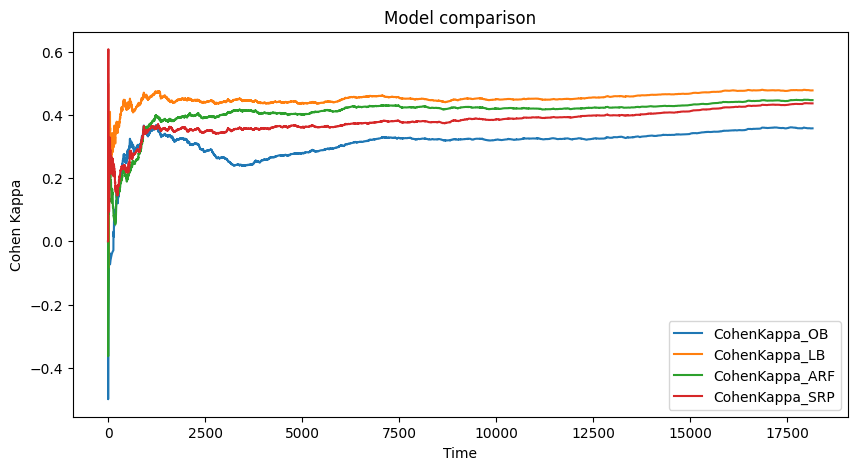

In [50]:
plot_comparison(steps_OB,steps_LB,steps_ARF,steps_SRP,"Model comparison",rolling=False)

## Concept Drift Impact

Concept drift can negatively impact learning methods if not properly handled. Multiple real-world applications suffer **model degradation** as the models can not adapt to changes in the data.

---
## `AGRAWAL` dataset

We will load the data from a csv file. The data was generated using the `AGRAWAL` data generator with 3 **gradual drifts** at the 5k, 10k, and 15k marks. It contains 9 features, 6 numeric and 3 categorical.

There are 10 functions for generating binary class labels from the features. These functions determine whether a **loan** should be approved.

| Feature    | Description            | Values                                                                |
|------------|------------------------|-----------------------------------------------------------------------|
| `salary`     | salary                 | uniformly distributed from 20k to 150k                                |
| `commission` | commission             | if (salary <   75k) then 0 else uniformly distributed from 10k to 75k |
| `age`        | age                    | uniformly distributed from 20 to 80                                   |
| `elevel`     | education level        | uniformly chosen from 0 to 4                                          |
| `car`        | car maker              | uniformly chosen from 1 to 20                                         |
| `zipcode`    | zip code of the town   | uniformly chosen from 0 to 8                                          |
| `hvalue`     | value of the house     | uniformly distributed from 50k x zipcode to 100k x zipcode            |
| `hyears`     | years house owned      | uniformly distributed from 1 to 30                                    |
| `loan`       | total loan amount      | uniformly distributed from 0 to 500k                                  |

**Class:** `y` | 0: no loan, 1: loan

**Samples:** 20,000

`elevel`, `car`, and `zipcode` are categorical features.

In [52]:
data = pd.read_csv("/content/agr_a_20k.csv")
features = data.columns[:-1]

Since there are several drifts, to better track the model behaviour, let's use a [Rolling Window](https://riverml.xyz/0.10.1/api/metrics/Rolling/) to compute the performance. It is a fixed size wrapper for computing metrics ovear a window. When the window is full, the oldest element is removed. In this way, the performance refers to the most recent data, possibly affected by a concept drift

## ADWIN Online Bagging

---
[ADWIN Online Bagging](https://riverml.xyz/0.21.2/api/ensemble/ADWINBaggingClassifier/) is the online bagging method with the addition of the ADWIN algorithm as a change detector. If concept drift is detected, the worst member of the ensemble (based on the error estimation by ADWIN) is replaced by a new (empty) classifier.

In [61]:
from river.ensemble import ADWINBaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = ADWINBaggingClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode']),
                          n_models=10,
                          seed=42)

metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=data[features], y=data['class'])

steps_OB = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)

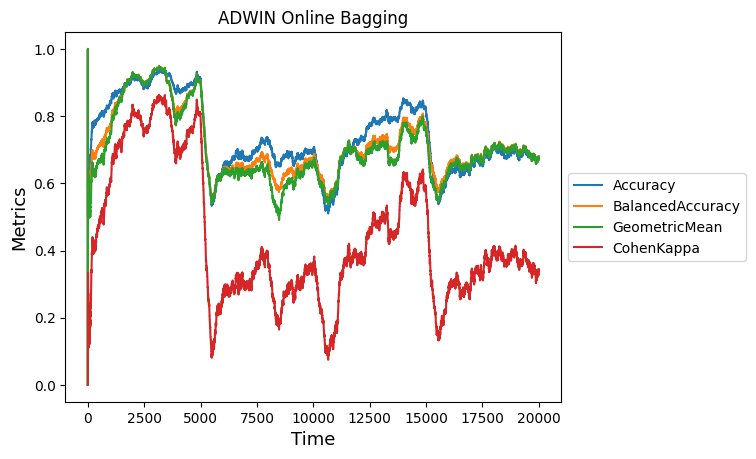

In [54]:
plot_results(steps_OB,'ADWIN Online Bagging',rolling=True)

## Leveraging Bagging

In [62]:
from river.ensemble import LeveragingBaggingClassifier
from river.tree import HoeffdingTreeClassifier

model = LeveragingBaggingClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode']),
                          n_models=10,
                          seed=42)
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=data[features], y=data['class'])

steps_LB = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)

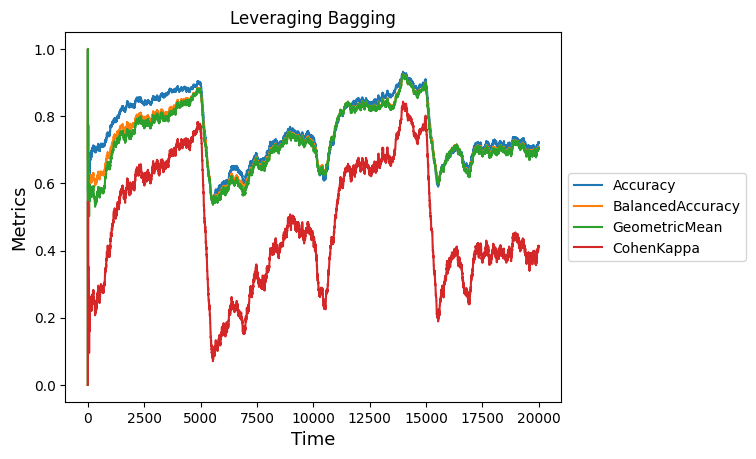

In [56]:
plot_results(steps_LB,'Leveraging Bagging',rolling=True)

## AdaptiveRandomForest

In [63]:
from river.forest import ARFClassifier

model = ARFClassifier(n_models=10,nominal_attributes=['elevel', 'car', 'zipcode'])
metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=data[features], y=data['class'])

steps_ARF = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)

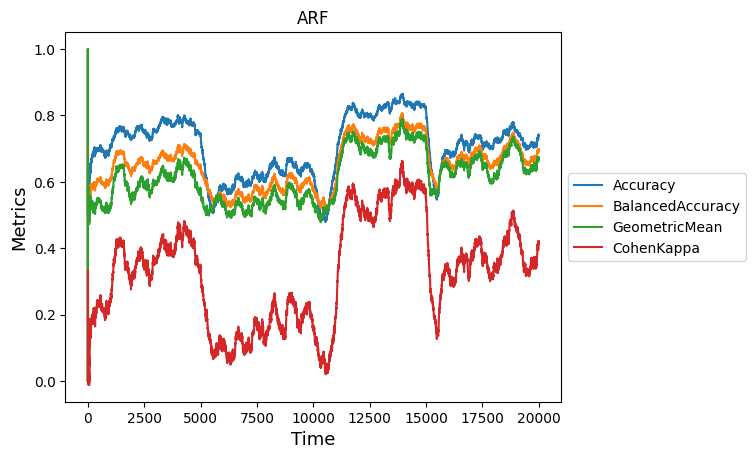

In [58]:
plot_results(steps_ARF,'ARF',rolling=True)

## StreamingRandomPatches
---
We set the drift and warning detection options

In [64]:
from river.ensemble import SRPClassifier
from river.tree import HoeffdingTreeClassifier
from river.drift import ADWIN

model = SRPClassifier(model=HoeffdingTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode']),
                      n_models=10,
                      drift_detector=ADWIN(delta=0.001),
                      warning_detector=ADWIN(delta=0.01),
                      seed=42)

metrics = Rolling(Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()]),window_size=500)
stream = iter_pandas(X=data[features], y=data['class'])

steps_SRP = iter_progressive_val_score(dataset=stream,model=model,metric=metrics,step=1)

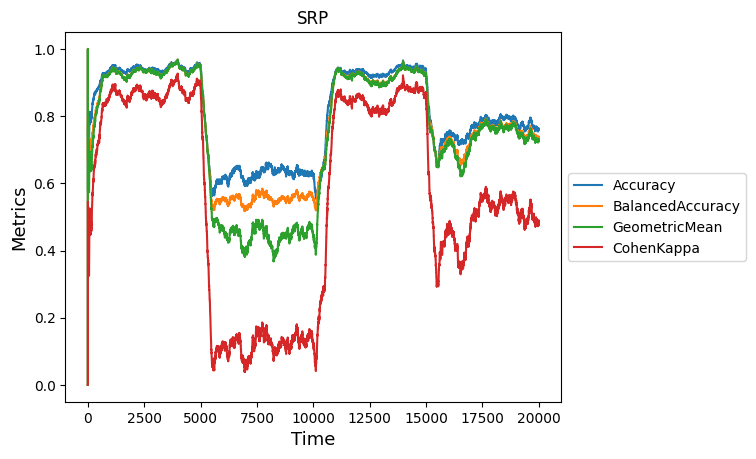

In [60]:
plot_results(steps_SRP,'SRP',rolling=True)

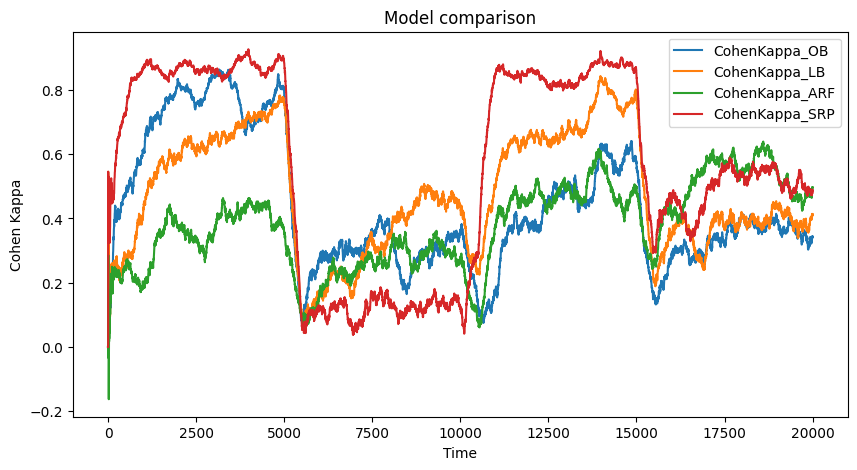

In [71]:
plot_comparison(steps_OB,steps_LB,steps_ARF,steps_SRP,"Model comparison",rolling=True)